# Intro to Argovis' Grid API

Argovis offers a growing list of gridded products, indexed and downloadable through its API. In this notebook, we'll illustrate some basic operations and handling of this data.

## Setup

In addition to importing a few python packages, make sure to plug in your Argovis API key for `API_KEY` in the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [1]:
import requests, xarray, pandas, math, datetime, copy
import numpy as np
from datetime import datetime, timedelta
from argovisHelpers import helpers as avh
import helpers
import grids_helper

API_KEY=''
API_PREFIX = 'https://argovis-api.colorado.edu/'

## Downloading Gridded Data

Argovis supports a number of grids through the same API endpoints:

 - `rg09`, [Roemmich-Gilson Argo gridded climatology](https://sio-argo.ucsd.edu/RG_Climatology.html)
 - `localGPintegral`, [LocalGP integrated fields](https://doi.org/10.5194/os-21-2463-2025)
 - `glodap`, [GLODAP V2 mapped product](https://glodap.info/index.php/mapped-data-product/)
 
 We can explore what categorical parameters and filters are available for these grids through the vocabulary routes as usual:

In [2]:
params = {
    'parameter': 'enum'
}

print('Parameters available:')
print(avh.query('grids/rg09/vocabulary', options=params, apikey=API_KEY, apiroot=API_PREFIX))

params = {
    'parameter': 'data'
}
print('data values available:')
print(avh.query('grids/rg09/vocabulary', options=params, apikey=API_KEY, apiroot=API_PREFIX))

Parameters available:
['data']
data values available:
['rg09_salinity', 'rg09_temperature']


We can query data from any one of the grids via the `/grids/{gridName}` route, and the usual temporospatial parameters that may be familiar from other Argovis APIs:

 - `startDate` (geo-constrained, see below, format YYYY-MM-DDTHH:MM:SSZ at GMT0): beginning of time window to query.
 - `endDate` (geo-constrained, see below, format YYYY-MM-DDTHH:MM:SSZ at GMT0): end of time window to query.
 - `polygon` (geo-constrained, see below, format [[lon0,lat0],[lon1,lat1],...,[lonN,latN],[lon0,lat0]]): geographical region to query.
 - `center` + `radius` (geo-constrained, see below, center format lon,lat ; raidus format distance in km): geographical region to query, defined as maximum distance (radius) from a point (center).
 - `verticalRange` (optional, format shallowlimit,deeplimit): only return levels between the limits specified, in meters or dbar as appropriate for the dataset in question.
 - `data` (optional, format comma separated list of keys): request the actual measurements to go with matched documents.
 
**Items marked 'geo-constrained'** are individually optional, but have soft limits based on estimates of how much data they will return. If you need to query a large area, consider making requests over a short timespan; or vice versa.

Let's try a simple request to download a piece of data from one of these grids, the North Atlantic from the first quarter of 2012 from the Roemmich-Gilson Argo temperature climatology.

In [3]:
params = {
  "startDate": '2012-01-01T00:00:00Z',
  "endDate": '2012-04-01T00:00:00Z',
  "polygon": [[-49.92187499999999,56.17002298293205],[-48.1640625,49.61070993807422],[-56.6015625,42.5530802889558],[-72.421875,35.746512259918504],[-72.421875,27.059125784374068],[-47.4609375,26.115985925333536],[-19.6875,27.371767300523047],[-12.65625,36.59788913307022],[-11.6015625,46.558860303117164],[-13.0078125,56.75272287205736],[-49.92187499999999,56.17002298293205]],
  "data": 'rg09_temperature'
}

rgdata = avh.query('grids/rg09', options=params, apikey=API_KEY, apiroot=API_PREFIX)

(If you need help constructing a polygon, try the following:

  - visit argovis.colorado.edu
  - click on the pentagon button to start drawing a polygon
  - draw a closed polygon
  - cut and paste the list of vertexes from the 'polygon' query string parameter that will appear in the URL bar.

Like most Argovis API requests, you get a list of documents matching your query. Let's have a look at the first record in what the API returned to us:

In [5]:
rgdata[0]

{'_id': '20120315000000_-67.5_27.5',
 'metadata': ['rg09_temperature_200401_Total', 'rg09_salinity_200401_Total'],
 'geolocation': {'type': 'Point', 'coordinates': [-67.5, 27.5]},
 'basin': 1,
 'timestamp': '2012-03-15T00:00:00.000Z',
 'data': [[22.513,
   22.505001,
   22.532,
   22.517,
   22.469,
   22.427,
   22.407,
   22.358,
   22.219999,
   22.004,
   21.593,
   21.268999,
   21.033001,
   20.812,
   20.59,
   20.314001,
   20.013,
   19.764999,
   19.486,
   19.150999,
   18.974001,
   18.832001,
   18.692999,
   18.552,
   18.423,
   18.323,
   18.219,
   18.105999,
   17.993,
   17.875,
   17.726,
   17.561001,
   17.337,
   16.910999,
   16.209999,
   15.365,
   14.434999,
   13.397,
   12.301,
   11.073,
   9.86,
   8.798,
   7.939,
   7.338,
   6.793,
   6.306,
   5.925,
   5.635,
   5.396,
   5.174,
   5.001,
   4.813,
   4.606,
   4.401,
   4.16,
   3.969,
   3.826,
   3.699]],
 'data_info': [['rg09_temperature'], ['units'], [['degree celcius (ITS-90)']]]}

By default, Argovis returns gridded data in a *profile-like* structure, with a schema similar to other Argovis APIs. Since a grid reports values at regular depths, those depths are reported in the metdata document associated with each grid profile in order to avoid trasmitting them over and over for default requests like this. We can look them up using the `/grids/metadata` route and the `metadata` key from the document in question:

In [6]:
metadata_params = {
    "id": rgdata[0]['metadata'][0]
}

rgmeta = avh.query('grids/meta', options=metadata_params, apikey=API_KEY, apiroot=API_PREFIX)
rgmeta

[{'_id': 'rg09_temperature_200401_Total',
  'data_type': 'temperature',
  'data_info': [['rg09_temperature'],
   ['units'],
   [['degree celcius (ITS-90)']]],
  'date_updated_argovis': '2023-01-27T18:43:01.679Z',
  'source': [{'source': ['Roemmich-Gilson Argo Climatology'],
    'url': 'https://sio-argo.ucsd.edu/gilson/argo_climatology/RG_ArgoClim_Temperature_2019.nc.gz'}],
  'levels': [2.5,
   10,
   20,
   30,
   40,
   50,
   60,
   70,
   80,
   90,
   100,
   110,
   120,
   130,
   140,
   150,
   160,
   170,
   182.5,
   200,
   220,
   240,
   260,
   280,
   300,
   320,
   340,
   360,
   380,
   400,
   420,
   440,
   462.5,
   500,
   550,
   600,
   650,
   700,
   750,
   800,
   850,
   900,
   950,
   1000,
   1050,
   1100,
   1150,
   1200,
   1250,
   1300,
   1350,
   1412.5,
   1500,
   1600,
   1700,
   1800,
   1900,
   1975],
  'level_units': 'dbar',
  'lattice': {'center': [0.5, 0.5],
   'spacing': [1, 1],
   'minLat': -64.5,
   'minLon': -179.5,
   'maxLat': 

Here we see some interesting metadata about the file that produced the first record in our list of grid estimates, including the levels by which we can interpret the `data` key: these lists are sorted identically, so the first element in a `data` list corresponds to a depth of 2.5 dbar, the first entry in the corresponding `levels` metadata key. All grid metadata documents also include a `lattice` key that describes the structure of the grid in latitude and longitude.

> **What does lattice center and spacing mean?** Each product with a regular grid indexed by argovis describes its grid with a centerpoint, which is an arbitrary point on the grid close to [0,0] denoted as [longitude, latitude]. Other grid points are found stepping along by the amount in `lattice.spacing`, denoted as [longitude step, latitude step].

If we're only interested in the grid estimates near the ocean surface, we can add a `verticalRange` filter to our data request:

In [7]:
filter_params = copy.deepcopy(params)
filter_params['verticalRange'] = '0,100'

rgSurfacedata = avh.query('grids/rg09', options=filter_params, apikey=API_KEY, apiroot=API_PREFIX)
rgSurfacedata[0]

{'_id': '20120315000000_-67.5_27.5',
 'metadata': ['rg09_temperature_200401_Total', 'rg09_salinity_200401_Total'],
 'geolocation': {'type': 'Point', 'coordinates': [-67.5, 27.5]},
 'basin': 1,
 'timestamp': '2012-03-15T00:00:00.000Z',
 'data': [[22.513,
   22.505001,
   22.532,
   22.517,
   22.469,
   22.427,
   22.407,
   22.358,
   22.219999,
   22.004]],
 'data_info': [['rg09_temperature'], ['units'], [['degree celcius (ITS-90)']]],
 'levels': [2.5, 10, 20, 30, 40, 50, 60, 70, 80, 90]}

Now our data records returned by the `grids/rg09` route only report levels within the range requested; also note when we customize the depth range requested, the custom-filtered list of levels appears directly on the data document. **When a key, such as levels, appears on a data document and that document's corresponding metadata document, the assigned value on the data document always takes precedence**.

## Ingestion by xarray

Xarray is a familiar pythonic data structure; we can transform a raw API response to an xarray with a helper similar to the following.

In [8]:
df = helpers.level_df(rgdata, 
                      ['rg09_temperature', 'longitude', 'latitude', 'timestamp'], 
                      per_level_pressures=rgmeta[0]['levels'], 
                      index=["latitude","longitude","timestamp","pressure"]
                     )
ds = df.to_xarray()

Now we can do all the usual xarray operations; lets see what the ranges of our coordinate variables are:

In [9]:
print('latitudes:',ds['latitude'].data)
print('longitudes:',ds['longitude'].data)
print('timestamps:',ds['timestamp'].data)
print('pressures:',ds['pressure'].data)

latitudes: [26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5
 40.5 41.5 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5
 54.5 55.5 56.5 57.5]
longitudes: [-71.5 -70.5 -69.5 -68.5 -67.5 -66.5 -65.5 -64.5 -63.5 -62.5 -61.5 -60.5
 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 -51.5 -50.5 -49.5 -48.5
 -47.5 -46.5 -45.5 -44.5 -43.5 -42.5 -41.5 -40.5 -39.5 -38.5 -37.5 -36.5
 -35.5 -34.5 -33.5 -32.5 -31.5 -30.5 -29.5 -28.5 -27.5 -26.5 -25.5 -24.5
 -23.5 -22.5 -21.5 -20.5 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5]
timestamps: ['2012-01-15T00:00:00.000000000' '2012-02-15T00:00:00.000000000'
 '2012-03-15T00:00:00.000000000']
pressures: [   2.5   10.    20.    30.    40.    50.    60.    70.    80.    90.
  100.   110.   120.   130.   140.   150.   160.   170.   182.5  200.
  220.   240.   260.   280.   300.   320.   340.   360.   380.   400.
  420.   440.   462.5  500.   550.   600.   650.   700.   750.   800.
  850.   900.   950.  1000.  1050.  1100.  11

We can easily select a slice of this array at constant pressure and time, to produce a possibly more conventional, map-like grid representation, and plot it with xarray's built in plots:

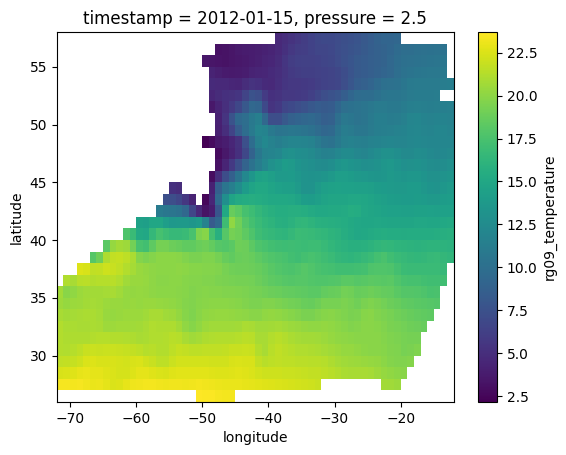

In [10]:
gridmap = ds.loc[{"timestamp":avh.parsetime('2012-01-15T00:00:00.000Z'), "pressure":2.5}]
gridmap['rg09_temperature'].plot()

## Area-weighted and meridional means over a longitude/latitude region

A common operation when considering gridded data is to weight a mean by area of grid cells, which changes with latitude. A helper to do this with Argovis grid data could look like the following.

In [11]:
dxr_aw = helpers.regional_mean(ds)
print(dxr_aw.loc[{"timestamp":avh.parsetime('2012-01-15T00:00:00.000Z'), "pressure":2.5}])
dxr_aw

<xarray.Dataset>
Dimensions:           ()
Coordinates:
    timestamp         datetime64[ns] 2012-01-15
    pressure          float64 2.5
Data variables:
    rg09_temperature  float64 16.27


<xarray.Dataset>
Dimensions:           (timestamp: 3, pressure: 58)
Coordinates:
  * timestamp         (timestamp) datetime64[ns] 2012-01-15 ... 2012-03-15
  * pressure          (pressure) float64 2.5 10.0 20.0 ... 1.9e+03 1.975e+03
Data variables:
    rg09_temperature  (timestamp, pressure) float64 16.27 16.28 ... 3.888 3.772

Let's plot the data after the spatial average over longitude and latitude:

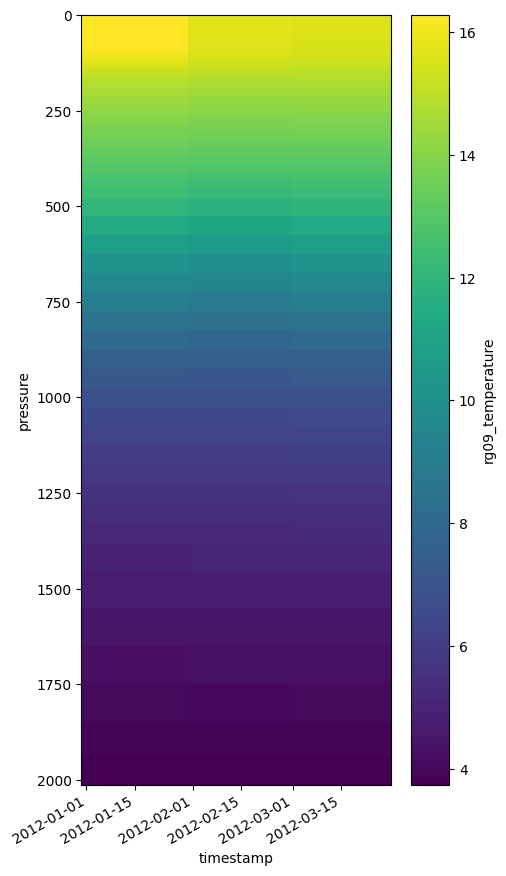

In [12]:
dxr_aw['rg09_temperature'].plot(y="pressure",yincrease=False,aspect=0.5, size=10)

Let's plot the data again, this time plotting one line per timestep:

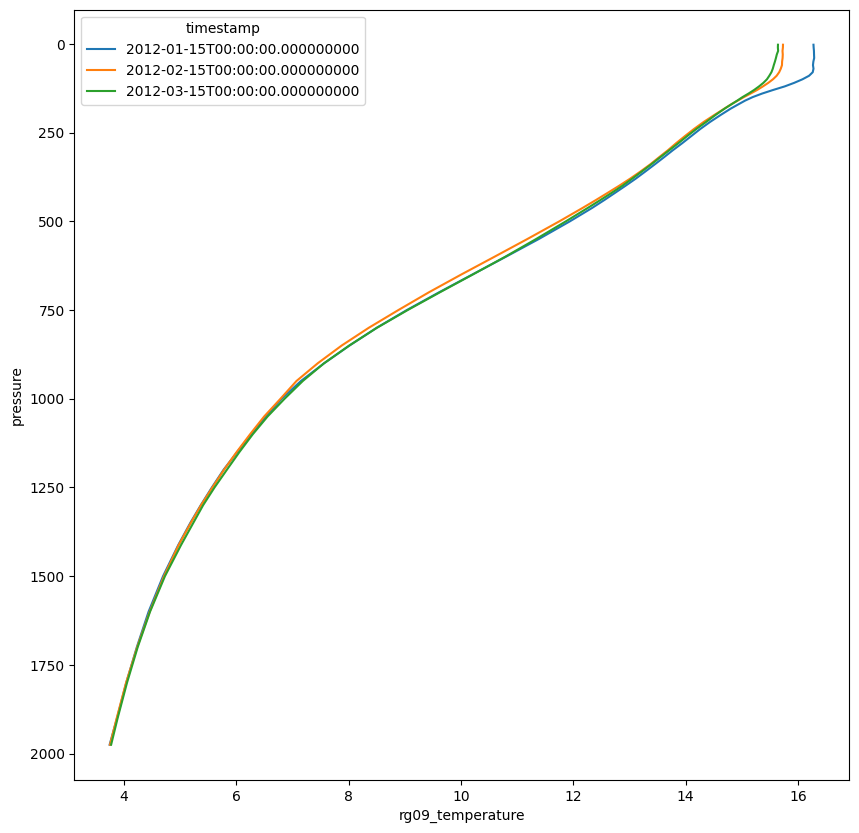

In [13]:
dxr_aw['rg09_temperature'].plot.line(y="pressure",yincrease=False,aspect=1, size=10)

We can also similarly perform a meridional weighted average:

In [14]:
ds

<xarray.Dataset>
Dimensions:           (latitude: 32, longitude: 60, timestamp: 3, pressure: 58)
Coordinates:
  * latitude          (latitude) float64 26.5 27.5 28.5 29.5 ... 55.5 56.5 57.5
  * longitude         (longitude) float64 -71.5 -70.5 -69.5 ... -13.5 -12.5
  * timestamp         (timestamp) datetime64[ns] 2012-01-15 ... 2012-03-15
  * pressure          (pressure) float64 2.5 10.0 20.0 ... 1.9e+03 1.975e+03
Data variables:
    rg09_temperature  (latitude, longitude, timestamp, pressure) float64 nan ...

In [15]:
dxr_mer = helpers.regional_mean(ds, form='meridional')
dxr_mer

<xarray.Dataset>
Dimensions:           (longitude: 60, timestamp: 3, pressure: 58)
Coordinates:
  * longitude         (longitude) float64 -71.5 -70.5 -69.5 ... -13.5 -12.5
  * timestamp         (timestamp) datetime64[ns] 2012-01-15 ... 2012-03-15
  * pressure          (pressure) float64 2.5 10.0 20.0 ... 1.9e+03 1.975e+03
Data variables:
    rg09_temperature  (longitude, timestamp, pressure) float64 21.49 ... 3.89

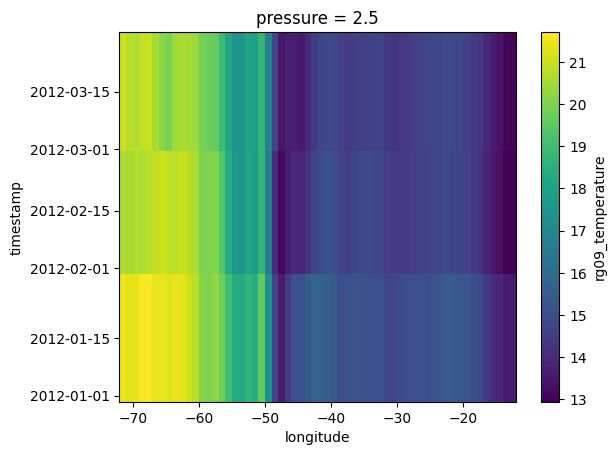

In [16]:
dxr_mer.sel(pressure=2.5)['rg09_temperature'].plot(y="timestamp")

## Accessing and visualizing Ocean Heat Content (OHC)

OHC fields in the following are by Kuusela and Giglio 2022 (https://doi.org/10.5281/zenodo.6131625) and are mapped using locally stationary Gaussian processes with data-driven decorrelation scales (Kuusela and Stein, 2018). A linear time trend was included in the estimate of the mean field (along with spatial terms and harmonics for the annual cycle). Mapping is done in latitude and longitude with monthly subsets of data for e.g. the 15-300 dbar pressure layer. The top layer of the pressure range is indicated in "levels".

In [38]:
params = {
  "startDate": '2012-01-01T00:00:00Z',
  "endDate": '2013-01-01T00:00:00Z',
  "polygon": [[-78,30],[-70,30],[-70,20],[-78,20],[-78,30]],
  "data": 'potential_temperature'
}
localGP = avh.query('grids/localGPintegral', options=params, apikey=API_KEY, apiroot=API_PREFIX)

metadata_params = {
    "id": localGP[0]['metadata'][0]
}
localGPmeta = avh.query('grids/meta', options=metadata_params, apikey=API_KEY, apiroot=API_PREFIX)

In [40]:
df_localGP = helpers.level_df(
    localGP, 
    ['potential_temperature', 'longitude', 'latitude', 'timestamp'], 
    per_level_pressures=['_'.join([str(x) for x in localGPmeta[0]['levels'][0]])], 
    index=["latitude","longitude","timestamp","pressure"]
)
ds_localGP = df_localGP.to_xarray()

In [41]:
ds_localGP

<xarray.Dataset>
Dimensions:                (latitude: 10, longitude: 8, timestamp: 12,
                            pressure: 1)
Coordinates:
  * latitude               (latitude) float64 20.5 21.5 22.5 ... 27.5 28.5 29.5
  * longitude              (longitude) float64 -77.5 -76.5 -75.5 ... -71.5 -70.5
  * timestamp              (timestamp) datetime64[ns] 2012-01-15 ... 2012-12-15
  * pressure               (pressure) object '15_50'
Data variables:
    potential_temperature  (latitude, longitude, timestamp, pressure) float64 ...

Let's plot a map of this potential temperature integral for January 2012:

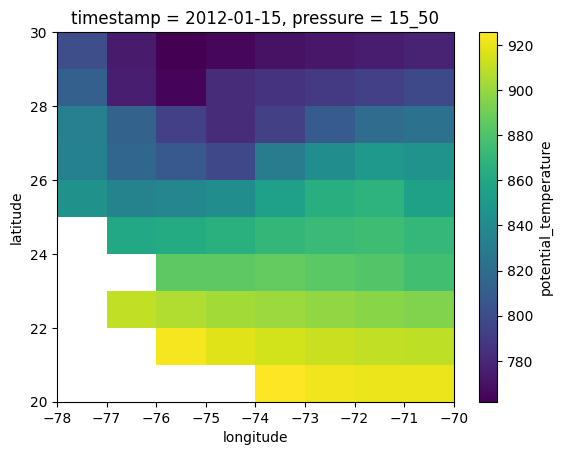

In [43]:
gridmap = ds_localGP.loc[{"timestamp":avh.parsetime('2012-01-15T00:00:00.000Z'),"pressure":'15_50'}]
gridmap['potential_temperature'].plot()

Let's now compute the area average in the selected region.

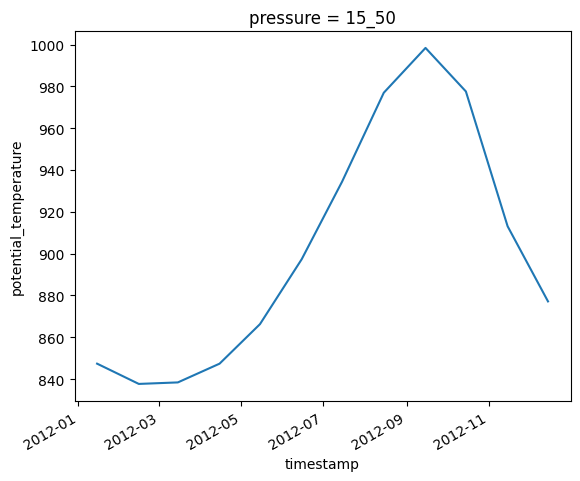

In [44]:
dxr_aw_localGP = grids_helper.areaweighted_region_mean(ds_localGP)
dxr_aw_localGP['potential_temperature'].plot()

## GLODAP Mapped data product

Argovis also serves the GLODAP V2.2016b mapped data product, via the endpoint `/grids/glodap`. This product is indexed and queried exactly as the other grid products, with the one special case that since GLODAP is a time-averaged product using data over 1972-2013, it doesn't have a meaningful time dimension to slice using `startDate` and `endDate`; the `timestamp` for all GLODAP data documents is set with a fill value of 1000-01-01T00:00:00Z.

In [21]:
params = {
    "data": 'oxygen'
}

glodap_data = avh.query('grids/glodap', options=params, apikey=API_KEY, apiroot=API_PREFIX)

In [22]:
params = {
    "id": 'glodapv2.2016b'
}

glodap_meta = avh.query('grids/meta', options=params, apikey=API_KEY, apiroot=API_PREFIX)

In [23]:
df = helpers.level_df(glodap_data, 
                      ['oxygen', 'longitude', 'latitude'], 
                      per_level_pressures=glodap_meta[0]['levels'], 
                      index=["latitude","longitude","pressure"]
                     )
ds = df.to_xarray()

In [24]:
dxr_zon = helpers.regional_mean(ds, form='zonal')
dxr_zon

<xarray.Dataset>
Dimensions:   (latitude: 168, pressure: 33)
Coordinates:
  * latitude  (latitude) float64 -77.5 -76.5 -75.5 -74.5 ... 86.5 87.5 88.5 89.5
  * pressure  (pressure) int64 0 10 20 30 50 75 ... 3500 4000 4500 5000 5500
Data variables:
    oxygen    (latitude, pressure) float64 322.1 321.8 319.5 ... 309.1 308.5

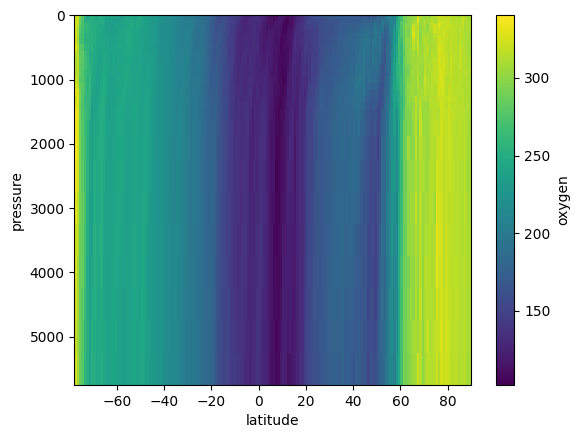

In [25]:
dxr_zon['oxygen'].plot(y="pressure", yincrease=False)